## Домашняя работа 4. 

Максимальный балл за задание - 10.

In [90]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import sklearn
import matplotlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [91]:
#your code here
df = pd.read_csv('/content/drive/MyDrive/Programming/ML/Занятие 7/data.adult.csv', sep = ',')
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**(0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [92]:
#df[df['occupation'] == '?']

In [93]:
#your code here
df_1 = df[(df != '?').all(axis=1)]
#df_1[df_1['occupation'] == '?']

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [94]:
#your code here
y = pd.get_dummies(df_1['>50K,<=50K'], drop_first=True)
X = df_1.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', '>50K,<=50K'], axis = 1)

In [95]:
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - kNN
 - SGD Linear Classifier
 - Naive Bayes Classifier
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
Для начала у первых двух алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации используйте 5-fold cv.

**(1.5 балла)** Для каждого из первых двух алгоритмов (kNN, SGD) подберите оптимальные значения указанных гиперпараметров. Постройте график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал (доверительный интервал задается границами [mean - std, mean + std]).

In [96]:
#your code here
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
sgd_lc = SGDClassifier()

cv_n = 5

In [97]:
clf_knn = GridSearchCV(estimator = knn, param_grid = {'n_neighbors': list(range(1, 8))}, cv = cv_n, scoring = 'roc_auc')

In [98]:
clf_sgd_lc = GridSearchCV(estimator = sgd_lc, param_grid = {'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron',
                                                                     'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive')}, cv = cv_n, scoring = 'roc_auc')

In [99]:
knn_fit_0 = clf_knn.fit(X, y)
sgd_fit_0 = clf_sgd_lc.fit(X, y)

sorted(sgd_fit_0.cv_results_.keys())

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_loss',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [100]:
#cv_batches = ['split'+str(i)+'_test_score' for i in range(cv_n)]

In [101]:
sgd_best_0 = sgd_fit_0.best_params_['loss']
sgd_mean_0 = sgd_fit_0.cv_results_['mean_test_score'].mean()

knn_best_0 = knn_fit_0.best_params_['n_neighbors']
knn_mean_0 = knn_fit_0.cv_results_['mean_test_score'].mean()

print('sgd_lc: ', sgd_best_0, '; mean_test_score: ', round(sgd_mean_0, 3), 
      '; knn: ', knn_best_0, '; mean_test_score: ', round(knn_mean_0, 3))

sgd_lc:  hinge ; mean_test_score:  0.567 ; knn:  4 ; mean_test_score:  0.635


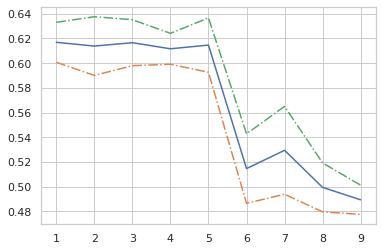

In [102]:
from matplotlib import pyplot as plt
import numpy as np


x_axis = list(range(1, 10))
y_axis_sgd = sgd_fit_0.cv_results_['mean_test_score'] 
y_std_lower_sgd = sgd_fit_0.cv_results_['mean_test_score'] - sgd_fit_0.cv_results_['std_test_score']
y_std_higher_sgd = sgd_fit_0.cv_results_['mean_test_score'] + sgd_fit_0.cv_results_['std_test_score']

plt.plot(x_axis, y_axis_sgd)
plt.plot(x_axis, y_std_lower_sgd, linestyle="-.")
plt.plot(x_axis, y_std_higher_sgd, linestyle="-.")


plt.show()


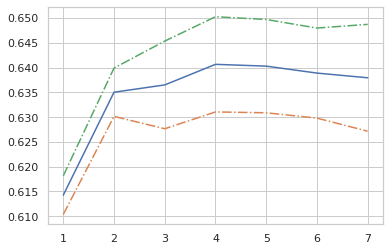

In [103]:
#knn
x_axis_knn = list(range(1, 8))
y_axis_knn = knn_fit_0.cv_results_['mean_test_score']
y_std_lower_knn = knn_fit_0.cv_results_['mean_test_score'] - knn_fit_0.cv_results_['std_test_score']
y_std_higher_knn = knn_fit_0.cv_results_['mean_test_score'] + knn_fit_0.cv_results_['std_test_score']

plt.plot(x_axis_knn, y_axis_knn)
plt.plot(x_axis_knn, y_std_lower_knn, linestyle="-.")
plt.plot(x_axis_knn, y_std_higher_knn, linestyle="-.")

plt.show()

Что вы можете сказать о получившихся графиках?  
* В случае с методом `kNN` подтверждается оптимальное значение соседей, полученное эмпирически [[1](https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb)]: k = 4.
* Для `SGD` среди возможных функций потерь (`loss`), оценивающих misfit модели, лучший результат показала [`modified_huber`](https://scikit-learn.org/stable/modules/sgd.html#sgd-mathematical-formulation), устойчивя к выбросам, которая при правильном выборе в бинарной классификации даёт $L(y_i, f(x_i)) = \max(0, 1 - y_i f(x_i))^2$, иначе $L(y_i, f(x_i)) = -4 y_i f(x_i)$. Т.е при правильном ответе (или хотя бы направлении) потери небольшие, в противном случае ф-ия накапливает misfit быстрее. 

**(0.75 балла)** Также подберём параметр регуляризации C в алгоритмах LogisticRegression и SVC.  
Scaling the regularization parameter (C): [link](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html)

In [104]:
#your code here
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

lr = LogisticRegression()
svc = SVC()

clf_lr = GridSearchCV(estimator = lr, param_grid = {'C': [0.1, 0.5, 1, 1.5, 2]}, cv = cv_n, scoring = 'roc_auc') 
clf_svc = GridSearchCV(estimator = svc, param_grid = {'C': [10**(-7), 10**(-6), 0.00001, 0.0001]}, cv = cv_n, scoring = 'roc_auc') 

In [105]:
lr_fit_0 = clf_lr.fit(X, y)
svc_fit_0 = clf_svc.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [106]:
lr_best_0 = lr_fit_0.best_params_['C']
lr_mean_0 = lr_fit_0.cv_results_['mean_test_score'].mean()

svc_best_0 = svc_fit_0.best_params_['C']
svc_mean_0 = svc_fit_0.cv_results_['mean_test_score'].mean()

In [107]:
print('clf_lr: ', lr_best_0, '; mean_test_score: ', round(lr_mean_0, 3), 
      '; clf_svc: ', svc_best_0, '; mean_test_score: ', round(svc_mean_0, 3))

clf_lr:  0.5 ; mean_test_score:  0.574 ; clf_svc:  1e-05 ; mean_test_score:  0.605


In [108]:
lr_fit_0.cv_results_['mean_test_score']

array([0.57412418, 0.57412441, 0.57412441, 0.57412441, 0.57412441])

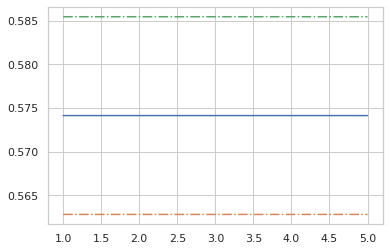

In [109]:
#sgd_lr
x_axis_lr = list(range(1, 6))

y_axis_lr = lr_fit_0.cv_results_['mean_test_score']
y_std_lower_lr = lr_fit_0.cv_results_['mean_test_score'] - lr_fit_0.cv_results_['std_test_score']
y_std_higher_lr = lr_fit_0.cv_results_['mean_test_score'] + lr_fit_0.cv_results_['std_test_score']

plt.plot(x_axis_lr, y_axis_lr)
plt.plot(x_axis_lr, y_std_lower_lr, linestyle="-.")
plt.plot(x_axis_lr, y_std_higher_lr, linestyle="-.")


plt.show()

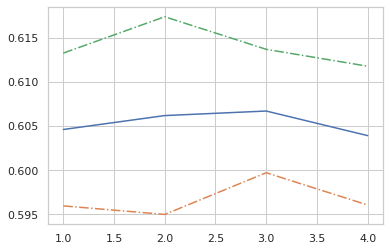

In [110]:
x_axis_svc = list(range(1, 5))

y_axis_svc = svc_fit_0.cv_results_['mean_test_score']
y_std_lower_svc = svc_fit_0.cv_results_['mean_test_score'] - svc_fit_0.cv_results_['std_test_score']
y_std_higher_svc = svc_fit_0.cv_results_['mean_test_score'] + svc_fit_0.cv_results_['std_test_score']

plt.plot(x_axis_svc, y_axis_svc)
plt.plot(x_axis_svc, y_std_lower_svc, linestyle="-.")
plt.plot(x_axis_svc, y_std_higher_svc, linestyle="-.")

plt.show()

**(0.75 балла)** Изучите документацию по алгоритму [Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) и подберите возможные гиперпараметры для этого алгоритма.

Из списка представленных моделей лучше всего подходит [Gaussian](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB), т.к. *на текущем этапе* рассматриваем только непрерывные (вообще говоря) признаки, которые подходят для применения названного методы.  
Иные методы, хотя и больше подходят для задачи классификации (если вообще не решают именно такую задачу), *но* требуют, чтобы объясняющие переменные ($X$) были бинарными.

In [111]:
#your code here
from sklearn.naive_bayes import GaussianNB

#var = [float(i) for i in range(0, 1, 0.1)]

gnb = GaussianNB()

clf_gnb = GridSearchCV(estimator = gnb, param_grid = {'var_smoothing': [0, 10**(-18), 10**(-12), 10**(-6)]}, cv = cv_n, scoring = 'roc_auc')

In [112]:
gnb_fit_0 = clf_gnb.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [113]:
sorted(gnb_fit_0.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_var_smoothing',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [114]:
gnb_best_0 = gnb_fit_0.best_params_['var_smoothing']
gnb_mean_0 = gnb_fit_0.cv_results_['mean_test_score'].mean()
#gnb_best_0

In [115]:
print('clf_gnb: ', gnb_best_0, '; mean_test_score: ', round(gnb_mean_0, 3))
#print('clf_gnb: ', gnb_fit_1.best_params_, 'mean_test_score: ', round(gnb_fit_1.cv_results_['mean_test_score'].mean(), 3))

clf_gnb:  1e-12 ; mean_test_score:  0.793


In [116]:
gnb_fit_0.cv_results_['mean_test_score']

array([0.82459593, 0.82459593, 0.82460438, 0.69803105])

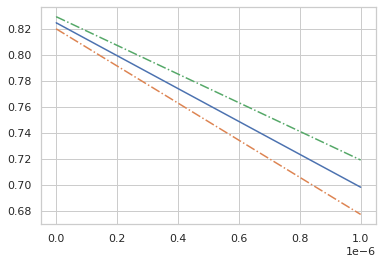

In [117]:
x_axis_gnb = [0, 10**(-18), 10**(-12), 10**(-6)]

y_axis_gnb = gnb_fit_0.cv_results_['mean_test_score']
y_std_lower_gnb = gnb_fit_0.cv_results_['mean_test_score'] - gnb_fit_0.cv_results_['std_test_score']
y_std_higher_gnb = gnb_fit_0.cv_results_['mean_test_score'] + gnb_fit_0.cv_results_['std_test_score']

plt.plot(x_axis_gnb, y_axis_gnb)
plt.plot(x_axis_gnb, y_std_lower_gnb, linestyle="-.")
plt.plot(x_axis_gnb, y_std_higher_gnb, linestyle="-.")


plt.show()

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**(0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масштабирование повлиять на работу этих алгоритмов?

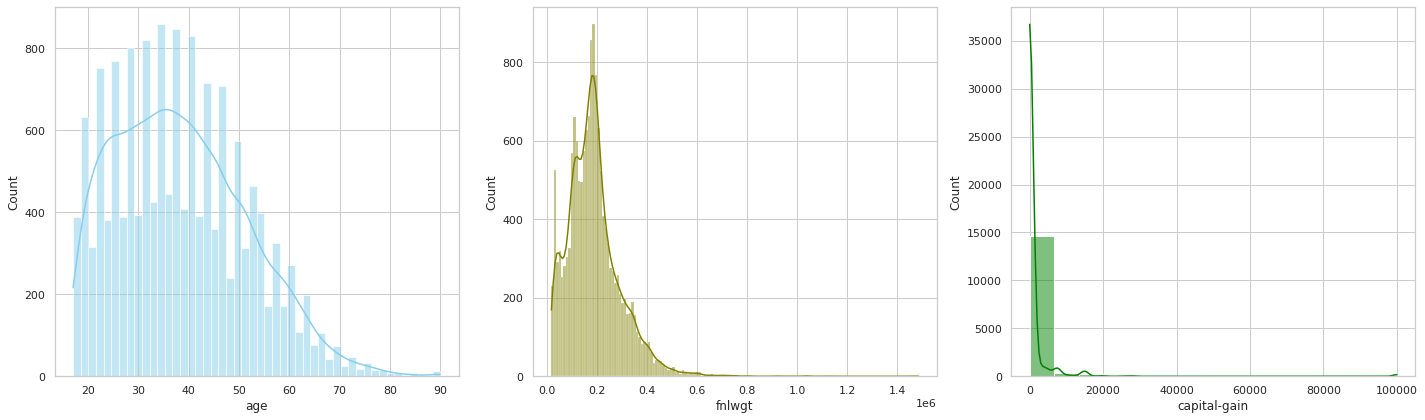

In [118]:
#your code here
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")  
fig,axs = plt.subplots(1,3, figsize = (20,6))

sns.histplot(data=X['age'], kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=X['fnlwgt'], kde=True, color="olive", ax=axs[1])
sns.histplot(data=X['capital-gain'], kde=True, color="green", ax=axs[2])

fig.tight_layout()


&emsp; При совсем грубом рассмотрении распределения похожи (biased to the right), даже частоты у `age` и [`fnlwgt`](https://www.kaggle.com/datasets/uciml/adult-census-income/discussion/32698) одинаковые, но диапазон значений совсем разный: возраст измеряется в десятках, репрезентативная доля (`fnlwgt`) в сотнях тысяч, а накопления распределены около нуля (с выбросами в районе 100 000).  
&emsp; Такой разброс повлияет на `kNN`, т.к. этот метод считает расстояние (очевидно, что расстояние как число лет и расстояние как накопления в USD, как минимум, имеют разный физ. смысл).  
&emsp; Второй метод - это `GaussianNB`, т.к в своей оценке он использует мат. ожидание и дисперсию.  
&emsp; В `SVC`, упрощённо говоря, исуществляется минимизация $||w||^2 = w^Tw$, вводя штраф за misfit, т.о. при отсутствии стандартизации удельное влияние коэф-ов $w$ будет сильно разниться, что приведёт к худшему качеству.  
&emsp; В `SGD` моделях в функцию loss подаётся оценённое значение параметра $f(x) = w^T x + b$, которое при отсутствии нормировки приведёт неэквивалентному влиянию коэф-ов модели.  
&emsp; В `LogisticRegression` логика аналогична `SVC`.

&emsp; Исходя из написанного, выглядит логичным сделать нормировку параметров.

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**(1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [119]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

class CustomScaler(TransformerMixin):
    def __init__(self, cols, scaler=None):
        self.cols = cols
        self.scaler = scaler or StandardScaler()
        
    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

In [120]:
num_cols = list(X.columns)
sc = CustomScaler(num_cols)
X_scaled = sc.fit_transform(X) #отмасштабированные

#X_scaled.head()
#X.head()

In [121]:
knn_fit_1 = clf_knn.fit(X_scaled, y)
sgd_fit_1 = clf_sgd_lc.fit(X_scaled, y)
lr_fit_1 = clf_lr.fit(X_scaled, y)
svc_fit_1 = clf_svc.fit(X_scaled, y)
gnb_fit_1 = clf_gnb.fit(X_scaled, y)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [122]:
knn_mean_1 = knn_fit_1.cv_results_['mean_test_score'].mean()

sgd_mean_1 = sgd_fit_1.cv_results_['mean_test_score'].mean()

lr_mean_1 = lr_fit_1.cv_results_['mean_test_score'].mean()

svc_mean_1 = svc_fit_1.cv_results_['mean_test_score'].mean()

gnb_mean_1 = gnb_fit_1.cv_results_['mean_test_score'].mean()

In [123]:
print('sgd_lc_1: ', round(sgd_mean_1, 3), '; sgd_lc_0: ', round(sgd_mean_0, 3))
print('knn_fit_1: ', round(knn_mean_1, 3), '; knn_fit_0: ', round(knn_mean_0, 3))
print('lr_fit_1: ', round(lr_mean_1, 3), '; lr_fit_0: ', round(lr_mean_0, 3))
print('svc_fit_1: ', round(svc_mean_1, 3), '; svc_fit_0: ', round(svc_mean_0, 3))
print('gnb_fit_1: ', round(gnb_mean_1, 3), '; gnb_fit_0: ', round(gnb_mean_0, 3))

sgd_lc_1:  0.72 ; sgd_lc_0:  0.567
knn_fit_1:  0.753 ; knn_fit_0:  0.635
lr_fit_1:  0.825 ; lr_fit_0:  0.574
svc_fit_1:  0.805 ; svc_fit_0:  0.605
gnb_fit_1:  0.825 ; gnb_fit_0:  0.793


Изменилось ли качество у некоторых алгоритмов?  
  Да, у всех! Предположения о влиянии нормализации подтвердились.

**(1,5 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае, например:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Для оставшихся трех алгоритмов самостоятельно определите, какие наборы гиперпараметров необходимо перебирать и осуществите перебор.

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой.

In [124]:
#your code here
import time
start_time = time.time()

clf_knn_all = GridSearchCV(estimator = knn, param_grid = {'n_neighbors': list(range(1, 8)), 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                                                          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'weights': ['uniform', 'distance']}, cv = cv_n, scoring = 'roc_auc')
knn_fit_2 = clf_knn_all.fit(X_scaled, np.ravel(y))
print("--- %s seconds ---" % (time.time() - start_time))

--- 363.19671750068665 seconds ---


In [125]:
start_time = time.time()

clf_sgd_lc_all = GridSearchCV(estimator = sgd_lc, param_grid = {'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron',
                                                                     'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'), 
                                                            'penalty': ['l2', 'l1', 'elasticnet', 'none']}, cv = cv_n, scoring = 'roc_auc')

sgd_fit_2 = clf_sgd_lc_all.fit(X_scaled, np.ravel(y))
print("--- %s seconds ---" % (time.time() - start_time))

--- 12.863112211227417 seconds ---


In [126]:
start_time = time.time()

clf_lr_all = GridSearchCV(estimator = lr, param_grid = {'C': [0.1, 0.5, 1, 1.5, 2], 'penalty': ['l2', 'none'], 
                                                    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}, cv = cv_n, scoring = 'roc_auc')

lr_fit_2 = clf_lr_all.fit(X_scaled, np.ravel(y))
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

--- 12.18503713607788 seconds ---


In [127]:
start_time = time.time()

clf_svc_all = GridSearchCV(estimator = svc, param_grid = {'C': [10**(-7), 10**(-6), 0.00001, 0.0001], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}, cv = cv_n, scoring = 'roc_auc')

svc_fit_2 = clf_svc_all.fit(X_scaled, np.ravel(y))
print("--- %s seconds ---" % (time.time() - start_time))

--- 375.0955982208252 seconds ---


In [128]:
clf_gnb = GridSearchCV(estimator = gnb, param_grid = {'var_smoothing': [0, 10**(-18), 10**(-12), 10**(-6)]}, cv = cv_n, scoring = 'roc_auc')

In [129]:
#gnb_fit_2 = clf_gnb.fit(X_scaled, y)

dct_best = {'knn_mean_2': knn_fit_2.cv_results_['mean_test_score'].mean(),
        'sgd_mean_2': sgd_fit_2.cv_results_['mean_test_score'].mean(),
        'lr_mean_2': lr_fit_2.cv_results_['mean_test_score'].mean(),
        'svc_mean_2': svc_fit_2.cv_results_['mean_test_score'].mean(),
        'gnb_mean_2': gnb_fit_1.cv_results_['mean_test_score'].mean()}
dct_best

{'gnb_mean_2': 0.8246113116344875,
 'knn_mean_2': 0.7515234819582476,
 'lr_mean_2': 0.8250230079244579,
 'sgd_mean_2': 0.7399532398309955,
 'svc_mean_2': 0.8111826693320531}

In [130]:
lr_fit_2.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

In [131]:
svc_fit_2.best_params_

{'C': 1e-07, 'kernel': 'linear'}

In [132]:
knn_fit_2.best_params_

{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 7,
 'weights': 'uniform'}

Хотя максимальное число соседей упирается в правую границу диапазона, эмпирически [считается](https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb), что их число должно лежать в диапазоне $[4:8]$, иначе модель, вероятнее всего, переобучена.  
Поэтому оставляем полученный результат как лучший.

In [133]:
sgd_fit_2.best_params_

{'loss': 'log', 'penalty': 'l1'}

In [134]:
gnb_fit_1.best_params_

{'var_smoothing': 1e-06}

Какой из алгоритмов даёт наилучшее качество?  
**1)** LogisticRegression() со средним качеством 0.8250;  
**2)** Далее идёт GaussianNB() со средним качеством 0.8246.

 

**(0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

Дольше всего обрабатывался SVC (~8 mins).

Один из парметров этой модели - это тип [ядра](https://scikit-learn.org/stable/modules/svm.html#svm-kernels)*, которое выполняет, как минимум, $n^2+n$ действий (для вычисления скалярного произведения): в рассматриваемом датасете $>15000$ строк. Умножим на 4 (число методов), что и приводит к столь значиельному времени вычислений.


\* оператор, переводящий неразделимый данные в $dim=2$ в пространство высшего порядка (например, $dim = n \times n$), где данные становятся разделимыми. 

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**(0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [135]:
#your code here
X_all = pd.get_dummies(df_1.drop(['>50K,<=50K'], axis = 1))
#X_all.head()

In [136]:
all_cols = list(X_all.columns)
sc = CustomScaler(all_cols)
X_all_scaled = sc.fit_transform(X_all) #отмасштабированные

Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры. 

**(0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [137]:
#your code here
from sklearn.model_selection import cross_val_score
dct_all = {'lr': cross_val_score(LogisticRegression(C= 0.4, penalty= 'l2', solver= 'lbfgs'), X_all_scaled, y, cv=cv_n),
         'svc': cross_val_score(SVC(C= 3, kernel= 'rbf'), X_all_scaled, y, cv=cv_n),
         'knn': cross_val_score(KNeighborsClassifier(algorithm = 'auto', metric = 'manhattan', n_neighbors = 7, weights = 'uniform'), X_all_scaled, y, cv=cv_n),
         'gnb': cross_val_score(GaussianNB(var_smoothing= 1e-06), X_all_scaled, y, cv=cv_n),
         'sgd': cross_val_score(SGDClassifier(loss=  'log', penalty = 'l1'), X_all_scaled, y, cv=cv_n)}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [138]:
for k in dct_all.keys():
  print('mean score for', k, dct_all[k].mean())

mean score for lr 0.8448555323116634
mean score for svc 0.840294825952071
mean score for knn 0.8199651447754842
mean score for gnb 0.6431883190420544
mean score for sgd 0.8389918306740836


In [139]:
#for i in sorted(dct_all.values(), reverse = True)[0:2]:
  #print(list(dct_all.keys())[list(dct_all.values()).index(i)])

**Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?**  
Да, *после нормировки* топ-2 результата были следующие:  
* mean score lr:  0.825  
* mean score gnb:  0.825 

Гауссовская апроксимация показала результат наравне с LogisticRegression(), но *добавление категориальных признаков* сильно ухудило качество первой (Gaussian) и улучшило качество последней (LR)  
* mean score for lr 0.845  
* mean score for gnb 0.643

Это связано с тем, что в модели Гаусса предполагается непрерывность всех признаков модели (не выполняется для категориальных), тогда как на LR() такие ограничения не [накладываются](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=Formally%2C%20in%20binary%20logistic%20regression,variable%20(any%20real%20value).).

## Смешивание моделей

Во всех предыдущих пунктах мы получили много хороших моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и логистическая регрессия). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**(1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [140]:
#your code here
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold

clf1 = LogisticRegression(C= 0.4, penalty= 'l2', solver= 'lbfgs')
clf2 = SVC(C= 3, kernel= 'rbf', probability = True)

combined_2 = VotingClassifier(estimators=[('lr', clf1), ('svm', clf2)], voting='soft')
cv = KFold(n_splits=5, random_state=None, shuffle=True)
scores = cross_val_score(combined_2, X_all_scaled, y, cv=cv, scoring='roc_auc')


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

In [141]:
scores

array([0.91129601, 0.90362312, 0.89243946, 0.90848873, 0.90335427])

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**(1 балл)** Для каждого типа классификатора (kNN, SGD classifier и т.д.), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [142]:
#your code here
my_dict = {'lr': dct_all['lr'],
         'svc': dct_all['svc'],
         'knn': dct_all['knn'],
         'gnb': dct_all['gnb'],
         'sgd': dct_all['sgd'],
         'lr+svc': scores}

### Вывод
&emsp; Основные параметры моделей: число соседей и тип растояния у kNN; у LR и SVC общий парметр [С](https://stackoverflow.com/questions/12809633/parameter-c-in-svm-standard-to-find-best-parameter), который даёт баланс между точностью подгона и выбора регуляризации (мЕньший С даёт преимущество более простым весам, l2).  Отдельно выделим ядро у SVC для разделения "сложных" данных.  
 &emsp; Наиболее сложная, как писалось выше, SVC из-за необходимости по дефолту считать dot-product. При этом по качеству она на равне с LR(), которая считается сильно быстрее. Их комбинация даёт даже лучшее качество, как видно на box-plot выше. Тем не менее, чтобы убедиться в отсутствии переобученности необходимы дальнейшие тесты.  
&emsp; Наименее пригодная модель - это Гауссова, т.к она подразумевает непрерывные признаки. Остальные модели более-менее дают одинаковый результат.  
&emsp; Сильный разброс SGD по фолдам, возможно, связан с тем, что на двумерной плоскости данные трудно разделить, поэтому даже лучшая функция потерь не даёт устойчивого результата. Для этого и нужно ядро в SVC, как описывалось выше.

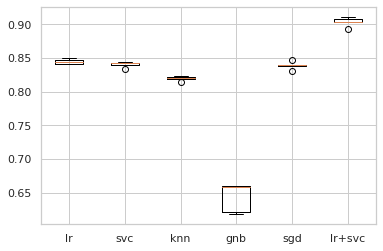

In [143]:
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())

plt.show()